In [15]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns

import statistics

import joblib

from sklearn.inspection import plot_partial_dependence

In [2]:
with open('RF_model_old/RF_parameter_split1.txt', 'r') as f:
    params_str = f.readline()
    params_dict = eval(params_str)
    f.close()

In [4]:
params_dict["bootstrap"]

True

In [17]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [25]:
def false_predict(y_true, y_pred):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3/"
    test_path =  "{}/test.csv".format(path)
    test_data = pd.read_csv(test_path)
    false_indices = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            false_indices.append(i)
    print(test_data.loc[false_indices])
    return false_indices
def feature_impotance(split):
    loaded_model = joblib.load('RF_model/RF_{}.joblib'.format(split))
    path = "../kitt/DATA_progress3/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    train_data = pd.read_csv(train_path)
    x_train = train_data[train_data.columns[2:]]
    # get the best random forest model
    best_rfc = loaded_model.best_estimator_
    # get the feature importances of the best random forest model
    importances = best_rfc.feature_importances_
    df = pd.DataFrame({'Variable':x_train.columns,
              'Importance':importances}).sort_values('Importance', ascending=False)
    print(df)
    return df

In [23]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')  
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new
def plot_cm(cm_val, save=False, title="-", split="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(title+" {}".format(split), fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(save, split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()

(114, 18)
(114, 16)
['B' 'M']
################# test set ##################
Best Threshold=1.000000
FPR: 0.0972
TPR: 0.8095
Confusion Matrix
----------------
[[65  7]
 [ 8 34]] 

----------------
split1
Sensitivity: 80.95%
Specificity: 90.28%
Accuracy: 86.84%
Precision: 82.93%
Sensitivity: 80.95%
Precision: 82.93%
F1: 81.93%


C:\Users\supak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


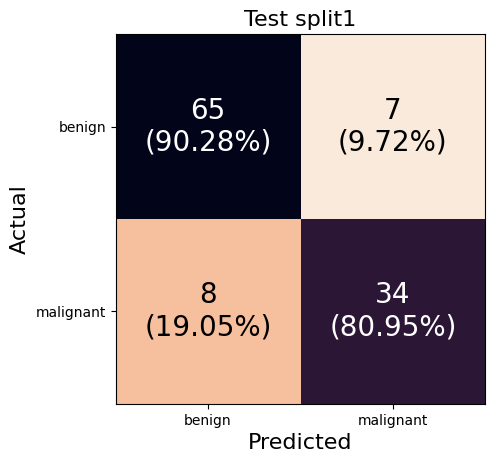

---------------------------------------
AUC test: 90.77%


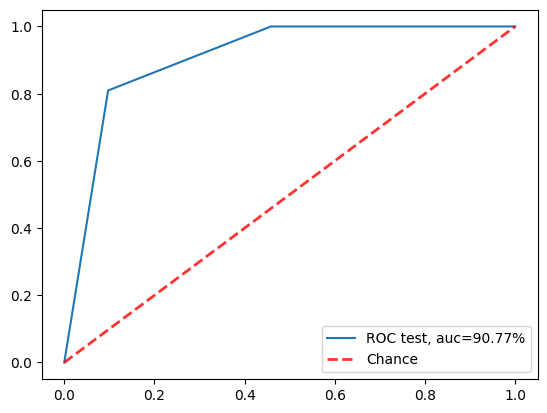

feature_impotance
                   Variable  Importance
7                   area_se    0.221958
3            concavity_mean    0.212695
1                 area_mean    0.180769
13          concavity_worst    0.120424
9              concavity_se    0.057329
0              texture_mean    0.036252
14           symmetry_worst    0.028087
2           smoothness_mean    0.025329
12         smoothness_worst    0.024153
15  fractal_dimension_worst    0.021925
6                texture_se    0.013242
5    fractal_dimension_mean    0.013189
10              symmetry_se    0.011742
11     fractal_dimension_se    0.011607
8             smoothness_se    0.010739
4             symmetry_mean    0.010559
false_predict
            id diagnosis  texture_mean  area_mean  smoothness_mean  \
5        91505         B         16.32      476.3          0.11580   
7     90401602         B         17.46      508.3          0.08044   
31      925311         B         29.37      386.0          0.07449   
41      

In [26]:
param = 2
split = "split1"
path = "../kitt/DATA_progress3_new/"
loaded_model = joblib.load('RF_model/RF_param{}_{}.joblib'.format(param,split))
test_path =  "{}/test.csv".format(path)
# Load the test set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)
# ################# test set ##################
label = ['benign','malignant']
print("################# test set ##################")
y_pred_test_raw = loaded_model.predict_proba(x_test)
y_pred_test = thresholding(y_test, y_pred_test_raw)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
print(split)
cal_score_all(cm_test)

# plot confusion matrix
plot_cm(cm_test, title="Test", split=split)

################## plot ROC curve ########################
# fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
# auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
# print("AUC validate: %.2f%%" % auc1)
print("AUC test: %.2f%%" % auc2)
# plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.legend(loc=4)
plt.show()
print("feature_impotance")
feature_impotance(split)
print("false_predict")
false_indices = false_predict(y_test, y_pred_test)

In [27]:
false_indices

[5, 7, 31, 41, 47, 51, 66, 76, 79, 82, 94, 98, 101, 106, 110]